$$
z_1 \sim N(µ_0; \Sigma_0)
$$
$$
z_t \sim N(G_{\alpha}(z_{t−1},u_{t−1}),S_{\beta}(z_{t−1},u_{t−1})) 
$$
$$
x_t ∼ Π(F_κ(z_t)).
$$

In [1]:
import numpy as np
import torch
from torch import Tensor

A toy example (classic Kalman filter)

Assuming
x are vectors of lenght 11, 
z are vectors of lenght 7,
u are vectros of length 3

In [3]:
m0 = Tensor(np.zeros(7))
S0 = Tensor(np.ones(7))

Gt = torch.randn((7, 7), requires_grad=True)
Bt = torch.randn((7, 3), requires_grad=True)
Ft = torch.randn((11, 7), requires_grad=True)  
St = torch.randn((7), requires_grad=True) # varience of z

def Ga(G, B, z, u):  # from z_{t-1} to z_t
    return G @ z + B @ u

def Fk(F, z):     # from z to x
    return F @ z

# as far as i understand, i will assume q is a normal distributioт N(phi @ xt, Sphi)
phi = torch.randn((7, 11), requires_grad=True)  
Sphi = torch.randn((7), requires_grad=True)
St = torch.randn((7), requires_grad=True) # varience of z

def q(x):
    return phi @ x + Sphi @ torch.normal(torch.zeros(7), torch.ones(7))

In [4]:
from scipy import stats as sps

In [4]:
a, b = np.meshgrid(np.arange(7), np.arange(7))
G_real = Tensor(sps.ortho_group.rvs(7))  # this is a normal matrix (preserve norm)
B_real = Tensor(np.concatenate([np.diag(np.ones(3)), np.diag(np.ones(3)), np.array([[1, 0, 0]])]))  
F_real = Tensor(np.concatenate([np.identity(7), np.zeros((4, 7))]))

In [5]:
def generate_sequence(length):
    z = [(1./7.)*torch.randn((7))]
    x = [Fk(F_real, z[-1])]
    
    u = [-(1./7.)*torch.sign(torch.sum(G_real @ z[-1])) * torch.ones(3)] 
    
    for _ in range(length - 1):
        z.append(Ga(G_real, B_real, z[-1], u[-1]))
        x.append(Fk(F_real, z[-1]))

        # this ensures norm of z will not grow thanks to actions. Now we can generate as long a sequence as needed
        u.append(-(1./7.)*torch.sign(torch.sum(G_real @ z[-1])) * torch.ones(3)) 
                    
    return z, x, u

In [6]:
z, x, u = generate_sequence(10000)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

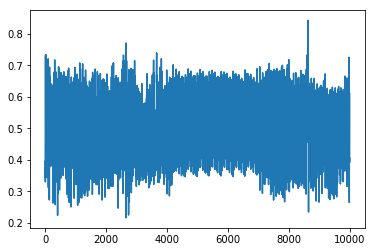

In [8]:
plt.plot([torch.norm(zi) for zi in z])

In [9]:
from tqdm import tqdm_notebook

T = 29
delta = 1
D = 7

optimizer = torch.optim.Adam([Gt, Bt, Ft, St, phi, Sphi], lr=1e-3)
l = []
error = []

for _ in tqdm_notebook(range(5000)):
    
    rand_i = np.random.randint(0, len(x) - T)
    
    batch_x = x[rand_i:rand_i + T] 
    batch_z = z[rand_i:rand_i + T] 
    batch_u = u[rand_i:rand_i + T] 

    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = 0
    # logp += (T-1) * D * torch.log(delta) * torch.prod(St)
    logp -= T * torch.sum(torch.log(SphiPos))   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    logp += torch.norm(phi @ batch_x[0])

    # shape [28, 7]
    mu_q_t_1T = (phi @ torch.stack(batch_x[1:]).permute(1, 0)).permute(1, 0)  # expectation of q_t for every t in [1, T]

    sample_z = ((phi @ torch.stack(batch_x).permute(1, 0)) + \
     (torch.normal(torch.zeros((50, T, 7)), 
                   torch.ones((50, T, 7))) * SphiPos).permute(0, 2, 1))

    # shape [50, 28, 7], random
    Gt_t_2T = (sample_z[:, :, :-1].permute(0, 2, 1) @ Gt) + (torch.stack(batch_u[:-1]) @ Bt.permute(1, 0))

    # 0.02 = (1/50) - averaging over random sample
    logp += 0.02*torch.sum((Gt_t_2T - mu_q_t_1T) * StPos * (Gt_t_2T - mu_q_t_1T))
    logp *= 0.5

    loss = 0.02*torch.sum(torch.norm((sample_z.permute(0, 2, 1) @ Ft.permute(1, 0)) - torch.stack(batch_x), dim=2))
    loss += logp
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)
    error.append(np.sum([torch.norm(Ft @ z[0] - x[0]) for zi, xi in zip(z[:100], x[:100])]))

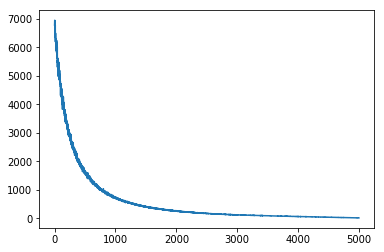

In [10]:
plt.plot(l)

In [11]:
error[0]

tensor(170.6324, grad_fn=<ThAddBackward>)

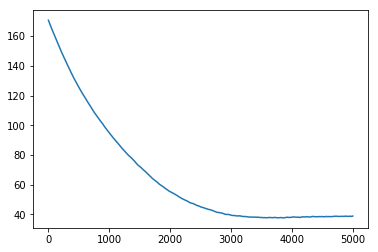

In [12]:
plt.plot(error)

In [27]:
D = 784
dim = D
z_dim = 100

Sphi = torch.zeros((z_dim), requires_grad=True)
St = torch.zeros((z_dim), requires_grad=True) # varience of z

Fk = torch.nn.Sequential(
    torch.nn.Linear(z_dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.Sigmoid()
)

Gk = torch.nn.Sequential(
    torch.nn.Linear(z_dim, z_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(z_dim, z_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(z_dim, z_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(z_dim, z_dim)
)

Q = torch.nn.Sequential(
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, z_dim)
)

In [6]:
from itertools import chain

In [7]:
X_train = np.load('train.npy')

In [8]:
X_train = X_train.reshape(60000, 5, -1)

In [9]:
X_train = Tensor(X_train.astype(int))

In [ ]:
from tqdm import tqdm_notebook

T = 5
delta = 1

optimizer = torch.optim.Adam(chain(Gk.parameters(), Fk.parameters(), Q.parameters(), [Sphi, St]), lr=1e-3)
l = []

for _ in tqdm_notebook(range(10000)):
    
    rand_i = np.random.randint(0, len(X_train))
    
    batch_x = X_train[rand_i] 

    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = 0
    # logp += (T-1) * D * torch.log(delta) * torch.prod(St)
    logp -= T * torch.sum(torch.log(SphiPos))   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    
    mu_q_t = Q(batch_x)
    
    logp += mu_q_t[0] @ mu_q_t[0] 
    
    # shape [50, 5, 784], random
    sample_z = mu_q_t + (SphiPos * torch.normal(torch.zeros((50, 5, z_dim)), 
                                                torch.ones((50, 5, z_dim))))
    # shape [50, 4, 784], random
    Gt_t_2T = Gk(sample_z[:, :4, :])

    # 0.02 = (1/50) - averaging over random sample
    logp += 0.02*torch.sum(((Gt_t_2T - mu_q_t[:4, :]) * (Gt_t_2T - mu_q_t[:4, :]) / StPos))
    logp *= 0.5

    p = Fk(sample_z)
    loss = torch.mean(Tensor([torch.nn.functional.binary_cross_entropy(input=pi.flatten(), 
                                                                       target=batch_x.flatten(),
                                                                       reduction='sum') for pi in p]))
    loss += logp
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)

In [167]:
loss

tensor(-0.8274, grad_fn=<ThAddBackward>)

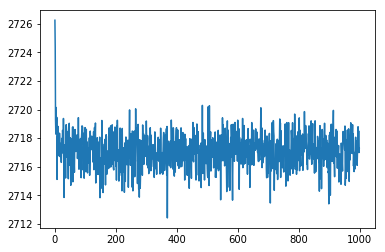

In [11]:
plt.plot(l)

In [29]:
mu_q_t_1T = (phi @ torch.stack(batch_x[1:]).permute(1, 0)).permute(1, 0)  # expectation of q_t for every t in [1, T]

    sample_z = ((phi @ torch.stack(batch_x).permute(1, 0)) + \
     (torch.normal(torch.zeros((50, T, 7)), 
                   torch.ones((50, T, 7))) * SphiPos).permute(0, 2, 1))

In [49]:
mu_q_t = Q(X_train[0])
# mu_G_t = Gk(X_train[0][:-1])

In [36]:
sample_z = ((phi @ torch.stack(batch_x).permute(1, 0)) + \
     (torch.normal(torch.zeros((50, T, 7)), 
                   torch.ones((50, T, 7))) * SphiPos).permute(0, 2, 1))

tensor([[-0.0130, -0.0204,  0.0388,  ...,  0.0429, -0.0312, -0.0287],
        [-0.0218, -0.0241,  0.0104,  ...,  0.0316, -0.0418, -0.0206],
        [-0.0119, -0.0393,  0.0104,  ...,  0.0243, -0.0384, -0.0104],
        [-0.0126,  0.0036,  0.0284,  ...,  0.0302, -0.0361, -0.0286]],
       grad_fn=<ThAddmmBackward>)

In [52]:
sample_z = (mu_q_t + (SphiPos * torch.normal(torch.zeros((50, 5, D)), 
                                            torch.ones((50, 5, D)))))

In [61]:
Gt_t_2T = Gk(sample_z[:, :4, :])

In [75]:
(Fk(sample_z) - X_train[0]) @ (Fk(sample_z) - X_train[0])

RuntimeError: invalid argument 2: wrong matrix size, batch1: 5x784, batch2: 5x784 at /opt/conda/conda-bld/pytorch-cpu_1532576596369/work/aten/src/TH/generic/THTensorMath.cpp:2312

tensor([[0.4924, 0.5099, 0.5081,  ..., 0.4955, 0.5032, 0.5144],
        [0.4909, 0.5088, 0.5088,  ..., 0.4947, 0.5034, 0.5153],
        [0.4913, 0.5093, 0.5078,  ..., 0.4951, 0.5036, 0.5152],
        [0.4906, 0.5091, 0.5087,  ..., 0.4950, 0.5036, 0.5147],
        [0.4937, 0.5096, 0.5102,  ..., 0.4958, 0.5028, 0.5165]],
       grad_fn=<MeanBackward0>)

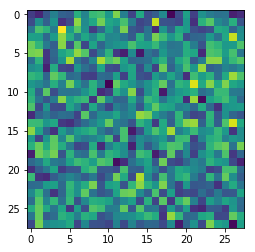

In [15]:
plt.imshow(Fk(Q(X_train[10]))[0].detach().reshape(28, 28))

In [16]:
Q(X_train[10])

tensor([[ 5.0173e-05, -1.4149e-04, -1.6212e-04,  ...,  1.6484e-04,
          7.8751e-05,  3.2018e-05],
        [ 2.7299e-05, -2.4293e-04, -7.5950e-05,  ...,  1.3742e-05,
          1.5753e-04,  1.9889e-04],
        [ 5.1674e-05, -2.5303e-04, -1.3542e-04,  ...,  2.2894e-04,
          1.7734e-04,  1.8600e-04],
        [-7.9956e-05, -3.0308e-04,  3.5489e-05,  ...,  4.5412e-05,
         -3.7789e-05, -1.3118e-04],
        [ 1.1431e-04, -1.4178e-04,  2.5264e-05,  ...,  9.8120e-05,
          5.1914e-05, -1.4777e-06]], grad_fn=<ThAddmmBackward>)

In [22]:
Q

TypeError: parameters() takes 1 positional argument but 2 were given